In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

In [21]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = map(lambda x: to_ix[x.lower()] if x in to_ix else to_ix['<unk>'], seq)
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
    
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, tag_count, tag_embedding_size):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embeds = nn.Embedding(tag_count, tag_embedding_size)
        self.lstm = nn.LSTM(embedding_dim + tag_embedding_size, hidden_dim // 2,
                            num_layers=1, bidirectional=True)
        
        # number of filters for 2, 3, 4 sized convs
        self.c1 = 4
        self.c2 = 2
        self.c3 = 2
        
        self.conv1 = nn.Conv2d(1, self.c1, (2, hidden_dim), padding=(1,0))
        self.conv2 = nn.Conv2d(1, self.c2, (3, hidden_dim), padding=(1,0))
        self.conv3 = nn.Conv2d(1, self.c3, (4, hidden_dim), padding=(2,0))

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim + self.c1 + self.c2 + self.c3, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        self.transitions.data[1][2] = -100000
        self.transitions.data[2][0] = -100000
        self.transitions.data[1][1] = -100000
        self.transitions.data[2][tag_to_ix[START_TAG]] = -100000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    
    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence, sentence_pos):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        pos_embeds_out = self.pos_embeds(sentence_pos).view(len(sentence), 1, -1)
        tot_embedding = torch.cat((embeds, pos_embeds_out), dim=2)
        lstm_out, self.hidden = self.lstm(tot_embedding, self.hidden)
        
        lstm_out = lstm_out.view(1, 1, len(sentence), self.hidden_dim)

        conv1_out = self.conv1(lstm_out)
        conv1_out = conv1_out.permute(0, 3, 2, 1)
        conv1_out = conv1_out.view(-1, self.c1)
        conv1_out = conv1_out[:len(sentence), :]
        
        conv2_out = self.conv2(lstm_out)
        conv2_out = conv2_out.permute(0, 3, 2, 1)
        conv2_out = conv2_out.view(-1, self.c2)
        conv2_out = conv2_out[:len(sentence), :]
        
        conv3_out = self.conv3(lstm_out)
        conv3_out = conv3_out.permute(0, 3, 2, 1)
        conv3_out = conv3_out.view(-1, self.c3)
        conv3_out = conv3_out[:len(sentence), :]
        
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        
        out = torch.cat((lstm_out, conv1_out, conv2_out, conv3_out), dim=1)
        out = self.hidden2tag(out)
        return out

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, sentence_pos, tags):
        feats = self._get_lstm_features(sentence, sentence_pos)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence, sentence_pos):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence, sentence_pos)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [6]:
import pickle, math
import numpy as np

START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 25
POS_EMBEDDING_DIM = 25
HIDDEN_DIM = 20

train_file_x = 'data/restaurants_train_x.txt'
train_file_y = 'data/restaurants_train_y.txt'

test_file_x = 'data/restaurants_test_x.txt'
test_file_y = 'data/restaurants_test_y.txt'

def make_list(path):
    f = open(path)
    return [x.split() for x in f]

train_x = make_list(train_file_x)
train_y = make_list(train_file_y)
test_x = make_list(test_file_x)
test_y = make_list(test_file_y)

with open('vec_dic.pickle', 'rb') as f:
    vec_dic = pickle.load(f)

word2id = {}
id2word = {}
embedding_matrix = []

for word in vec_dic:
    word2id[word] = len(word2id)
    id2word[len(word2id)-1] = word
    embedding_matrix.append(vec_dic[word])
            
word2id['<unk>'] = len(word2id)
id2word[len(word2id)-1] = '<unk>'

# add the embedding corresponding to random word to the embedding_matrix
embedding_matrix.append(np.random.randn(EMBEDDING_DIM).tolist())

In [7]:
from nltk import pos_tag
# now lets encode the pos tags
pos2id = {}

def update_pos2id(word):
    if word in pos2id:
        return pos2id[word]
    pos2id[word] = len(pos2id)
    return pos2id[word]

train_pos = []

for sentence in train_x:
    train_pos.append(map(update_pos2id, [x[1] for x in pos_tag(sentence)]))
pos2id['<unk>'] = len(pos2id)

# save pos2id to use in production code
with open('pos2id.pickle', 'wb') as f:
    pickle.dump(pos2id, f)
    
test_pos = []
for sentence in test_x:
    test_pos.append(map(lambda tag: pos2id[tag] if tag in pos2id else pos2id['<unk>'], [x[1] for x in pos_tag(sentence)]))


In [8]:
# load the glove vectors and save to a pickle_file
len(id2word)
# word2id['<unk>']

1193515

In [9]:
len(embedding_matrix)
# len(word2id)

1193515

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
HIDDEN_DIM = 20

# 100, 40 -- 1st epoch 35
tag2id = {"0": 0, "1": 1, "2": 2, START_TAG: 3, STOP_TAG: 4}

model = BiLSTM_CRF(len(word2id), tag2id, EMBEDDING_DIM, HIDDEN_DIM, len(pos2id), POS_EMBEDDING_DIM)
model.word_embeds.weight = nn.Parameter(torch.Tensor(embedding_matrix))
# model = torch.load("best_model_lstm_crf_pos.pt")
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# Check predictions before training
# with torch.no_grad():
#     precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
#     precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long)
#     print(model(precheck_sent))

best_f = 0
scores = []

for epoch in range(
        30):  # again, normally you would NOT do 300 epochs, it is toy data
    for x, x_pos, y in zip(train_x, train_pos, train_y):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(x, word2id)
        sentence_pos = torch.tensor(x_pos, dtype=torch.long)
        targets = torch.tensor([tag2id[t] for t in y], dtype=torch.long)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, sentence_pos, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()
        
        
    print('epoch done!')
    
    if epoch%1==0:
        precision = 0
        recall = 0
        s = 0
        g = 0
        s_g = 0
        
        for x, x_pos, y in zip(test_x, test_pos, test_y):
            sentence_in = prepare_sequence(x, word2id)
            sentence_pos = torch.tensor(x_pos, dtype=torch.long)
            _, prediction = model(sentence_in, sentence_pos)

            prediction = torch.LongTensor(prediction)
            y = torch.LongTensor(map(int, y))
            
            prediction = prediction.tolist()
            y = y.tolist()
            
            i = 0
            while(i < len(prediction)):
                if prediction[i]==1:
                    s += 1
                    if y[i]==1:
                        g += 1
                        i += 1
                        if i>=len(prediction):
                            s_g += 1
                            continue
                        while(i<len(prediction) and prediction[i]==2):
                            if not y[i]==2:
                                i += 1
                                break
                            i += 1
                        else:
                            s_g += 1
                    else:
                        i += 1
                elif y[i]==1:
                    g += 1
                    i += 1
                else:
                    i += 1
        
        precision += float(s_g) / s
        recall += float(s_g) / g
        print(precision, recall)
#             if len(y) == (prediction==y).sum().tolist():
#                 correct += 1
        
        f_score = 2 * precision * recall / (precision + recall)
        scores.append(f_score)
        
        if best_f < f_score:
            best_f = f_score
            # save the model
            print("Saving the best model up to now")
            torch.save(model, "best_model_lstm_crf_cnn_pos.pt")
        
        print "f_score %f" % f_score

# Check predictions after training
# with torch.no_grad():
#     precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
#     print(model(precheck_sent))
# We got it!

epoch done!
(0.5534709193245778, 0.5694980694980695)
Saving the best model up to now


/usr/local/lib/python2.7/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


f_score 0.561370
epoch done!
(0.5936883629191322, 0.581081081081081)
Saving the best model up to now
f_score 0.587317
epoch done!
(0.620253164556962, 0.6621621621621622)
Saving the best model up to now
f_score 0.640523
epoch done!
(0.6340508806262231, 0.6254826254826255)
f_score 0.629738
epoch done!
(0.6687763713080169, 0.611969111969112)
f_score 0.639113
epoch done!
(0.6409774436090225, 0.6583011583011583)
Saving the best model up to now
f_score 0.649524
epoch done!
(0.6812227074235808, 0.6023166023166023)
f_score 0.639344
epoch done!
(0.660377358490566, 0.6081081081081081)
f_score 0.633166


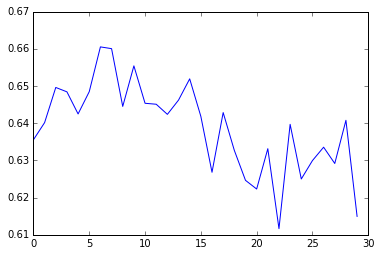

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(scores)